In [1]:
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

## Neural Network

In this notebook, we will work with the qm7b data.

In [2]:
qm7b = pd.read_csv('http://faculty.washington.edu/tingcao/wordpress/wp-content/uploads/2020/10/qm7b.csv');
qm7b.head()

,id,ae_pbe0,emax_zindo,imax_zindo,homo_zindo,lumo_zindo,e1_zindo,ip_zindo,ea_zindo,homo_pbe0,...,homo_gw,lumo_gw,p_pbe0,p_scs,n_H,n_C,n_N,n_O,n_S,n_Cl
0,1,-420.933746,39.694626,0.621841,-16.013,4.162,36.768073,15.72523,-3.98613,-10.9488,...,-14.1341,1.0870,2.534576,2.43222,4,1,0,0,0,0
1,2,-718.419189,22.622486,0.628328,-13.549,3.684,11.717433,13.41121,-3.49181,-9.5577,...,-12.5472,1.1186,4.332028,4.44500,6,2,0,0,0,0
2,3,-570.024841,22.940671,0.709060,-10.160,1.231,7.137266,9.75211,-0.82042,-7.8768,...,-10.4383,1.9456,4.173282,3.92308,4,2,0,0,0,0
3,4,-410.286163,15.973798,2.228480,-10.706,2.145,4.624107,10.46577,-1.89847,-8.4021,...,-11.1629,1.1958,3.512394,3.32175,2,2,0,0,0,0
4,5,-868.855408,17.900516,0.556174,-12.365,3.825,10.311655,11.96491,-3.57487,-8.3534,...,-10.8132,1.2002,5.480160,5.78632,6,3,0,0,0,0


Let our predictors be 'homo_zindo', 'lumo_zindo', target be 'e1_zindo' (first excitation energy).

Do the train-test splitting first.

In [3]:
x = qm7b[['homo_zindo', 'lumo_zindo']].values
y = qm7b['e1_zindo'].values
x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=0.20,
                                                    random_state=111)

## Normalize the data

The `StandardScaler` normalize the data by: $X_i = \frac{X_i - \mu _i}{\sigma _i}$,

$X_i$ is the $i$-th feature, $\mu_i$ is the mean value of the feature $i$ in the training data, $\sigma_i$ is the variance of the feature $i$ in the training data.

In [4]:
scaler = StandardScaler().fit(x_train)
x_train_norm = scaler.transform(x_train)
x_test_norm = scaler.transform(x_test)

Histogram before normalization:

(array([ 19.,  33.,  97., 249., 304., 268.,  87.,  88., 256.,  42.]),
 array([-2.284 , -1.6731, -1.0622, -0.4513,  0.1596,  0.7705,  1.3814,
         1.9923,  2.6032,  3.2141,  3.825 ]),
 <a list of 10 Patch objects>)

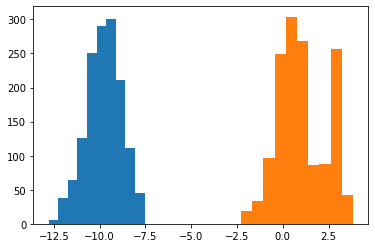

In [5]:
plt.hist(x_test[:,0])
plt.hist(x_test[:,1])

Histogram after normalization:

(array([ 19.,  33.,  97., 249., 304., 268.,  87.,  88., 256.,  42.]),
 array([-2.5437301 , -2.0774628 , -1.6111955 , -1.1449282 , -0.67866089,
        -0.21239359,  0.25387371,  0.72014101,  1.18640831,  1.65267562,
         2.11894292]),
 <a list of 10 Patch objects>)

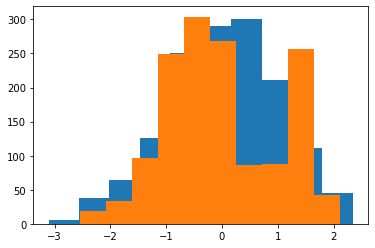

In [6]:
plt.hist(x_test_norm[:,0])
plt.hist(x_test_norm[:,1])

## Train and test neural network

We construct a neural network model with one input layer, one hidden layer and one output layer, and wrap it in a function `nnmodel1()`.

<img width="512" alt="NN" src="https://www.astroml.org/_images/fig_neural_network_1.png"></a>

(picture from https://www.datastuff.tech/machine-learning/convolutional-neural-networks-an-introduction-tensorflow-eager/)

The picture illustrates how neural network works. (the number of neurons are different in our case) 

* `Dense`: Dense implements the operation: `output = activation(dot(input, kernel) + bias)` where `activation` is the element-wise activation function passed as the activation argument, `kernel` is a weights matrix created by the layer, and `bias` is a bias vector created by the layer (only applicable if use_bias is True).


In [7]:
def nnmodel1():
    #Create nn model using sequential function, specify that the NN has to be sequential, stacked one by one
    model = Sequential()
    
    #input layer
    #model.add adds layers to the model we created
    #Kernel is the "w" in the image, all the connections between the input & hiden layers
    #2 means we only want to pass 2 neurons in the input layer = number features in the data set
    #input dimension is the # columns in training data set
    
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='relu'))
    
    #hidden layer
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    
    #ouptput layer
    model.add(Dense(1, kernel_initializer='normal'))
    

    #loss specifies how we calculate the loss function of the NN, because this is regression model we use Mean squared error
    #optimization code adam
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Train the NN:

* `epochs`: specify the number of epochs. In each epoch, ALL the training data will be propagated through the network once.
* `batch_size`: the number of samples that will be propagated through the network in a batch. The weights in the network will be updated after each batch (this might depend the optimization algorithm you choose).
* `validation_split`: split the given ratio of training data into validation data, the rest is training data. Note that only the training data will be used to train the model, the validation data is just used for evaluate the accuracy of the model after each epoch. 

The overall process:

    For each epoch:
        For each batch:
            For each training data in the batch:
                propagate through the network
            Update the weights
            Get the accuracy of training dataset
        For each validation data in the batch:
            Get the accuracy of validation dataset
            

In [8]:
np.random.seed(111)
estimator = KerasRegressor(build_fn=nnmodel1) #specify the nn object called estimator
#build fn = nnmodel1 
history = estimator.fit(x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0)

In [9]:
history.history

{'loss': [32.35867670900333,
  15.610334837658804,
  2.87082300497138,
  1.2941912174471664,
  0.9262151467627373,
  0.8960305636220344,
  0.8917722776069404,
  0.8874281080860035,
  0.8786208402542841,
  0.8714742045965254,
  0.862991816508844,
  0.8562296620930697,
  0.851611800568938,
  0.8447031541640714,
  0.8411105438048795,
  0.8393474828382457,
  0.8360159551381571,
  0.8368786664729779,
  0.8333449820307224,
  0.8323754562107426],
 'val_loss': [25.961304848935423,
  5.087969046680867,
  1.604329414728309,
  0.8167262818633008,
  0.7036820309502738,
  0.6926483061133313,
  0.6878325298052876,
  0.6838737012458449,
  0.6827522851839787,
  0.6675602555775842,
  0.6596365333104334,
  0.6561126876778963,
  0.6519844008594,
  0.6453083425509829,
  0.6516480819016945,
  0.6415573413632497,
  0.6452693363197711,
  0.6381377743071869,
  0.6371571734672835,
  0.6388561670519725]}

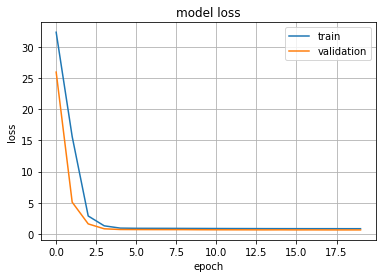

In [10]:
plt.plot(range(20),history.history['loss'])
plt.plot(range(20),history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch') #epoch
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

In [11]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history.history['loss'][-1], history.history['val_loss'][-1]))
#the -1 means the last value of the list

final MSE for train is 0.83 and for validation is 0.64


Test the NN:

In [12]:
test_loss = estimator.model.evaluate(x_test_norm, y_test)
print("test set mse is %.2f" % test_loss)

1443/1443 [==============================] - 0s 30us/sample - loss: 0.7580
test set mse is 0.76


Predict with the NN:

In [13]:
y_test_predict = estimator.predict(x_test_norm)

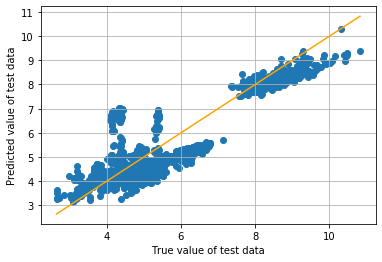

In [14]:
plt.scatter(y_test, y_test_predict)
plt.xlabel("True value of test data")
plt.ylabel("Predicted value of test data")
plt.plot(np.arange(min(y_test),max(y_test),0.01),np.arange(min(y_test),max(y_test),0.01),c='orange')
plt.grid()

## Tune the neural network

### Tune the activation function

Different types of activation functions are shown below. `ReLu` is a linear activation function. If all the activation function are linear in the neural network, the model will be essentially linear. `Sigmoid` and `Tanh` are two examples of non-linear activation functions. By using different activation functions in different layers, you could allow the model to have more complex mappings between the inputs and outputs.

A full list of available activation functions in Keras can be found here: https://keras.io/api/layers/activations/ .

In our example, you can set the activation function of each layer by the parameter `activation` in the `Dense()` function. 

[-5, 5, -1.2, 1.2]

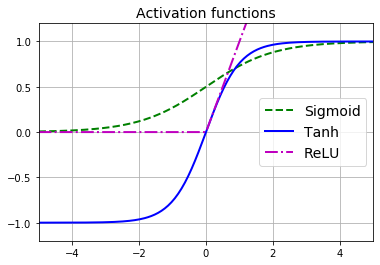

In [15]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")

plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

### Exercise 1: 
Please define a new neural network by simply changing the parameter `activation` in the HIDDEN LAYER of the `nnmodel1()` from `relu` to a non-linear one of your choice, and train it with our training data.
Is your result improved compared to `nnmodel1()` in terms of test error?

In [16]:
def nnmodel2():
    model = Sequential()
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(20, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model 

In [17]:
np.random.seed(200)
estimator2 = KerasRegressor(build_fn=nnmodel2) #specify the nn object called estimator
history2 = estimator2.fit(x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0)

In [18]:
#history2.history

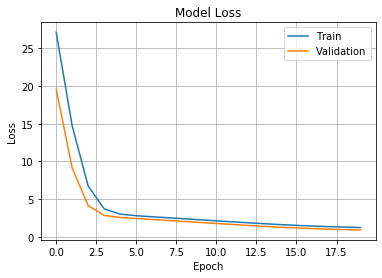

In [19]:
plt.plot(range(20),history2.history['loss'])
plt.plot(range(20),history2.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid()
plt.show()

In [20]:
print("Final MSE for Train is %.2f and for Validation is %.2f" % 
      (history2.history['loss'][-1], history2.history['val_loss'][-1]))
print()
test_loss2 = estimator2.model.evaluate(x_test_norm, y_test)
print("Test set mse is %.2f" % test_loss2)
print()
print('The MSE for the ReLU activation function was 0.85 ')
print('The MSE for the sigmoid activation was 1.2, so these are worse results compared to nnmodel1')

Final MSE for Train is 1.22 and for Validation is 0.90

1443/1443 [==============================] - 0s 30us/sample - loss: 1.0360
Test set mse is 1.04

The MSE for the ReLU activation function was 0.85 
The MSE for the sigmoid activation was 1.2, so these are worse results compared to nnmodel1


### Tune learning rate of the optimizer

The training of neural network can be regarded as an optimization process of searching the minimum of the loss function. Imagine you're searching a fastest way of going down a mountain (i.e. searching the 'minimum' of the mountain), one strategy you can take is going the direction with the steepest descent of height. And after going one step in that direction, you need to determine the new steepest descent since your location is updated. This is basically the main idea of the optimization algorithm, and the size of the step you take in one direction is the so called learning rate.

For more details about the Gradient Descent algorithm and learning rate, you can check out this page: https://towardsdatascience.com/gradient-descent-algorithm-and-its-variants-10f652806a3

<img width="512" alt="Trajectory towards local minimum" src="https://miro.medium.com/max/1400/1*70f9PB-RwFaakqD6lfp4iw.png"></a>

The `Adam` optimization we use here is a stochastic gradient descent method. The learning rate can be specified by the parameter `lr` in the `keras.optimizers.Adam()`. The default value is 0.001, let's change it to 0.1.

For all the available optimizers in Keras, please see this page: https://keras.io/api/optimizers/

In [46]:
def nnmodel3():
    model = Sequential()
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    optimizer = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

In [47]:
np.random.seed(111)
estimator3 = KerasRegressor(build_fn=nnmodel3)
history3 = estimator3.fit(x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0)

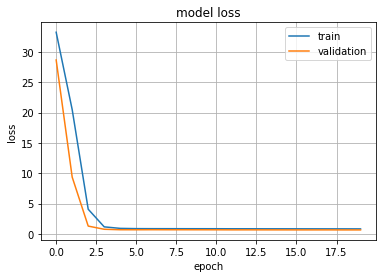

In [48]:
plt.plot(range(20),history3.history['loss'])
plt.plot(range(20),history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch') #epoch
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

In [24]:
print("final MSE for train is %.2f and for validation is %.2f" % 
      (history3.history['loss'][-1], history3.history['val_loss'][-1]))

final MSE for train is 0.71 and for validation is 0.57


In [25]:
test_loss3 = estimator3.model.evaluate(x_test_norm, y_test)
print("test set mse is %.2f" % test_loss3)

1443/1443 [==============================] - 0s 30us/sample - loss: 0.6448
test set mse is 0.64


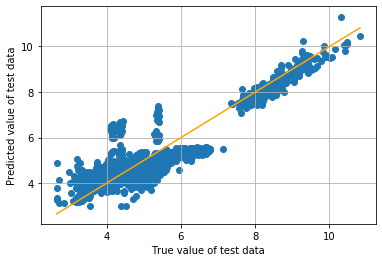

In [26]:
y_test_predict3 = estimator3.predict(x_test_norm)
plt.scatter(y_test, y_test_predict3)
plt.xlabel("True value of test data")
plt.ylabel("Predicted value of test data")
plt.plot(np.arange(min(y_test),max(y_test),0.01),np.arange(min(y_test),max(y_test),0.01),c='orange')
plt.grid()

### Exercise 2:
* Please try some other learning rate value. Is it always better to have larger learning rate? Please explain. 

In [27]:
print('When the learning rate value was 1, the MSE was 3.83 ')
print('When the Learning Rate Value was 0.1, the MSE was 0.53 ')
print('When the learning rate value was 0.01, the MSE was 0.62')
print('When the learning rate value was 0.001, the MSE was 0.65')
print('So a smaller learning rate value is not necessarily always better to reduce the error.')

When the learning rate value was 1, the MSE was 3.83 
When the Learning Rate Value was 0.1, the MSE was 0.53 
When the learning rate value was 0.01, the MSE was 0.62
When the learning rate value was 0.001, the MSE was 0.65
So a smaller learning rate value is not necessarily always better to reduce the error.


## Tune the number of layers
### Exercise 3: 
* Please add an extra hidden layer to the `nnmodel3`(the new layer will be right before the output layer).  The number of neurons, kernal initializer, and activation function of the new layer are up to your choice. Train the new model on the training data, and evaluate: final mse for train,validation, test set mse. Make a scatter plot of predicted value of test data vs. true value of test data. 

In [58]:
def nnmodel3():
    model = Sequential()
    model.add(Dense(2, input_dim=x_train_norm.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(Dense(20, kernel_initializer='normal', activation='relu'))
    #My New Hidden Layer
    model.add(Dense(40, kernel_initializer='normal', activation='sigmoid'))
    model.add(Dense(1, kernel_initializer='normal'))
    optimizer = keras.optimizers.Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

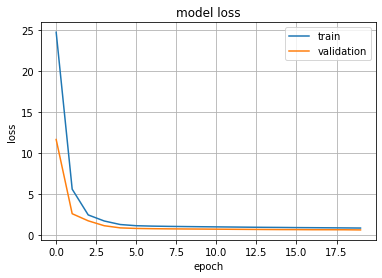

In [59]:
np.random.seed(210)
estimator3 = KerasRegressor(build_fn=nnmodel3)
history3 = estimator3.fit(x_train_norm, y_train, validation_split=0.33, epochs=20, batch_size=32, verbose=0)    

plt.plot(range(20),history3.history['loss'])
plt.plot(range(20),history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch') #epoch
plt.legend(['train', 'validation'], loc='upper right')
plt.grid()
plt.show()

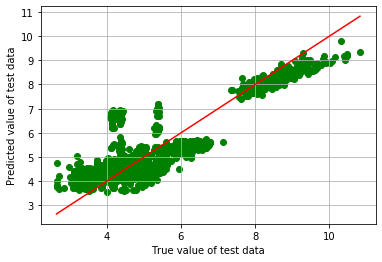

In [60]:
y_test_predict3 = estimator3.predict(x_test_norm)
plt.scatter(y_test, y_test_predict3,c='g')
plt.xlabel("True value of test data")
plt.ylabel("Predicted value of test data")
plt.plot(np.arange(min(y_test),max(y_test),0.01),np.arange(min(y_test),max(y_test),0.01),c='red')
plt.grid()

In [57]:
print("The final MSE for train is %.2f and for validation is %.2f" % 
      (history3.history['loss'][-1], history3.history['val_loss'][-1]))
test_loss3 = estimator3.model.evaluate(x_test_norm, y_test)
print("test set mse is %.2f" % test_loss3)

The final MSE for train is 0.99 and for validation is 0.72
1443/1443 [==============================] - 0s 30us/sample - loss: 0.8510
test set mse is 0.85
